# Анализ источников трафика и перераспределение бюджета

#### Предобработка и создание рабочих таблиц
#### Продуктовые метрики
1. DAU, WAU и MAU;
2. Cколько раз за день пользователи в среднем заходят на сайт;
3. Cколько времени пользователи проводят на сайте. Продолжительность типичной пользовательской сессии за весь период. ;
4. Retention Rate.
#### Метрики электронной коммерции
1. Сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки;
2. Среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев;
3. Средний чек;
4. LTV не менее 6 месяцев.
#### Маркетинговые метрики
1. Общая сумма расходов на маркетинг;
2. Средний CAC на одного покупателя для всего проекта и для каждого источника трафика;
3. ROMI.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

visits = pd.read_csv('C:\\Users\T\Documents\Практикум\Портфолио проектов практикумов/project_5.1 visits_log.csv', sep = ',', encoding="utf-8")
display(visits.head(5))
visits.columns = [x.lower() for x in visits.columns]


orders = pd.read_csv('C:\\Users\T\Documents\Практикум\Портфолио проектов практикумов/project_5.2 orders_log.csv', sep = ',', encoding="utf-8")
display(orders.head(5))

costs = pd.read_csv('C:\\Users\T\Documents\Практикум\Портфолио проектов практикумов/project_5.3 costs.csv', sep = ',', encoding="utf-8")
display(costs.head(5))


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [2]:
#приведем таблицу visits к необходимым типам данным
visits['visit_end_ts'] = pd.to_datetime(visits['end ts'])
visits['visit_start_ts'] = pd.to_datetime(visits['start ts'])

##добавим год,день,неделю и месяц в таблицу visits(по времени начала сессии)
visits['visit_dt']=visits['visit_start_ts'].dt.date
visits['visit_month'] = visits['visit_start_ts'].astype('datetime64[M]')
visits['visit_week'] = visits['visit_start_ts'].astype('datetime64[W]')
visits['visit_year'] = visits['visit_start_ts'].astype('datetime64[Y]')

visits.head(5)

,device,end ts,source id,start ts,uid,visit_end_ts,visit_start_ts,visit_dt,visit_month,visit_week,visit_year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:38:00,2017-12-20 17:20:00,2017-12-20,2017-12-01,2017-12-14,2017-01-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 17:21:00,2018-02-19 16:53:00,2018-02-19,2018-02-01,2018-02-15,2018-01-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-06-29,2017-01-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20 11:23:00,2018-05-20 10:59:00,2018-05-20,2018-05-01,2018-05-17,2018-01-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-27,2017-12-01,2017-12-21,2017-01-01


In [3]:
#найдем время первой сессии
first_visits=visits.groupby('uid')['visit_start_ts'].min().reset_index()
first_visits.name = 'first_visits'


first_visits['first_visit_dt'] = first_visits['visit_start_ts'].dt.date
first_visits['first_visit_month'] = first_visits['first_visit_dt'].astype('datetime64[M]')
first_visits['first_visit_week'] = first_visits['first_visit_dt'].astype('datetime64[W]')
first_visits=first_visits.rename(columns={'visit_start_ts':'min_visit_start_ts'})

first_visits.head(5)

,uid,min_visit_start_ts,first_visit_dt,first_visit_month,first_visit_week
0,11863502262781,2018-03-01 17:27:00,2018-03-01,2018-03-01,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2018-02-01,2018-02-01
2,297729379853735,2017-06-07 18:47:00,2017-06-07,2017-06-01,2017-06-01
3,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2017-09-14
4,325320750514679,2017-09-30 14:29:00,2017-09-30,2017-09-01,2017-09-28


In [4]:
#смеджерим visits и first_visits
visits_full =pd.merge(visits,first_visits, on='uid')
visits_full.head(5)

#добавим столбец с разницами между месяцем первой сессии и иной, под названием длительность жизни когорты
visits_full['cohort_lifetime'] = visits_full['visit_month'] - visits_full['first_visit_month']
visits_full['cohort_lifetime'] = visits_full['cohort_lifetime'] / np.timedelta64(1,'M')
visits_full['cohort_lifetime'] = visits_full['cohort_lifetime'].round().astype('int')

visits_full.head()

,device,end ts,source id,start ts,uid,visit_end_ts,visit_start_ts,visit_dt,visit_month,visit_week,visit_year,min_visit_start_ts,first_visit_dt,first_visit_month,first_visit_week,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:38:00,2017-12-20 17:20:00,2017-12-20,2017-12-01,2017-12-14,2017-01-01,2017-12-20 17:20:00,2017-12-20,2017-12-01,2017-12-14,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 17:21:00,2018-02-19 16:53:00,2018-02-19,2018-02-01,2018-02-15,2018-01-01,2018-02-19 16:53:00,2018-02-19,2018-02-01,2018-02-15,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-06-29,2017-01-01,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-06-29,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20 11:23:00,2018-05-20 10:59:00,2018-05-20,2018-05-01,2018-05-17,2018-01-01,2018-03-09 20:05:00,2018-03-09,2018-03-01,2018-03-08,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09 20:33:00,2018-03-09 20:05:00,2018-03-09,2018-03-01,2018-03-08,2018-01-01,2018-03-09 20:05:00,2018-03-09,2018-03-01,2018-03-08,0


In [5]:
#приведем таблицу заказы к необходимым типам данным
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
orders = orders.rename(
columns={'Buy Ts':'buy_ts','Uid':'uid','Revenue':'revenue'})

##добавим день,неделю и месяц в таблицу заказы
orders['buy_dt']=orders['buy_ts'].dt.date
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['order_week'] = orders['buy_ts'].astype('datetime64[W]')

orders.head()

,buy_ts,revenue,uid,buy_dt,order_month,order_week
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01


In [6]:
#найдем время первого заказа
first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders.name = 'first_orders'

first_orders['first_order_dt'] = first_orders['buy_ts'].dt.date
first_orders['first_order_month'] = first_orders['first_order_dt'].astype('datetime64[M]')
first_orders['first_order_week'] = first_orders['first_order_dt'].astype('datetime64[W]')
first_orders=first_orders.rename(columns={'buy_ts':'min_buy_ts'})

first_orders.head(10)


,uid,min_buy_ts,first_order_dt,first_order_month,first_order_week
0,313578113262317,2018-01-03 21:51:00,2018-01-03,2018-01-01,2017-12-28
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-01
2,2429014661409475,2017-10-11 18:33:00,2017-10-11,2017-10-01,2017-10-05
3,2464366381792757,2018-01-28 15:54:00,2018-01-28,2018-01-01,2018-01-25
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-23
5,3077748354309989,2018-03-03 12:33:00,2018-03-03,2018-03-01,2018-03-01
6,3605148382144603,2017-09-21 20:56:00,2017-09-21,2017-09-01,2017-09-21
7,3753586865891862,2018-03-03 13:50:00,2018-03-03,2018-03-01,2018-03-01
8,4808417689019433,2018-01-09 23:32:00,2018-01-09,2018-01-01,2018-01-04
9,4992223027560440,2018-04-04 13:54:00,2018-04-04,2018-04-01,2018-03-29


In [7]:
#приведем таблицу затраты к необходимым типам данным
costs['dt'] = pd.to_datetime(costs['dt'])

##добавим день,неделю и месяц в таблицу затраты
costs['dt']=costs['dt'].dt.date
costs['cost_month'] = costs['dt'].astype('datetime64[M]')
costs['cost_week'] = costs['dt'].astype('datetime64[W]')

costs.head()

,source_id,dt,costs,cost_month,cost_week
0,1,2017-06-01,75.20,2017-06-01,2017-06-01
1,1,2017-06-02,62.25,2017-06-01,2017-06-01
2,1,2017-06-03,36.53,2017-06-01,2017-06-01
3,1,2017-06-04,55.00,2017-06-01,2017-06-01
4,1,2017-06-05,57.08,2017-06-01,2017-06-01


2.1. Продуктовые метрики
2.1.1. Рассчитайте DAU, WAU и MAU. Вычислите средние значения этих метрик за весь период;
2.1.2. Определите, сколько раз за день пользователи в среднем заходят на сайт;
2.1.3. Исследуйте, сколько времени пользователи проводят на сайте. Узнайте продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, постройте график распределения. Изменение продолжительности сессий во времени изучать необязательно;
2.1.4. Рассчитайте Retention Rate, применяя когортный анализ. Найдите средний Retention Rate на второй месяц «жизни» когорт.

## Продуктовые метрики


Среднее количество уникальных пользователей в день: uid    907.991758
dtype: float64
Среднее количество уникальных пользователей в неделю: uid    5621.703704
dtype: float64
Среднее количество уникальных пользователей в месяц: uid    23228.416667
dtype: float64


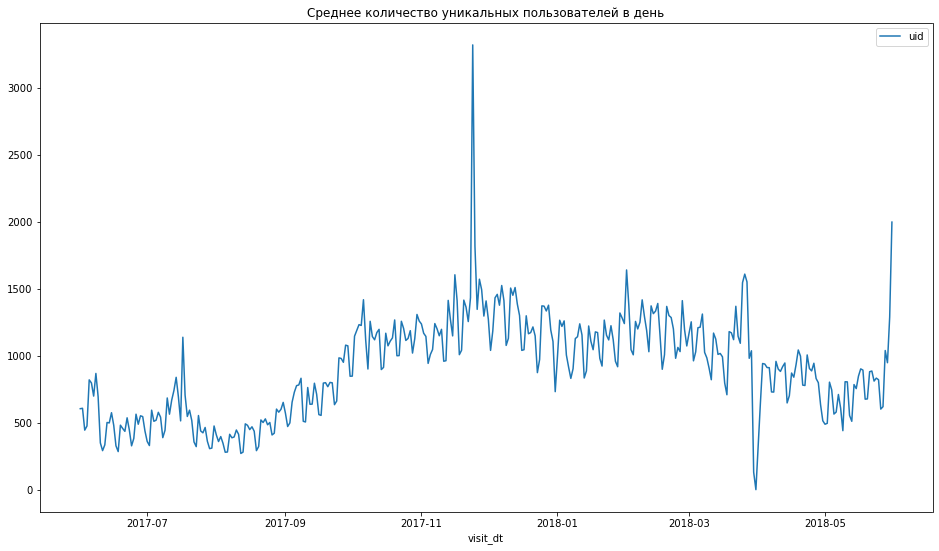

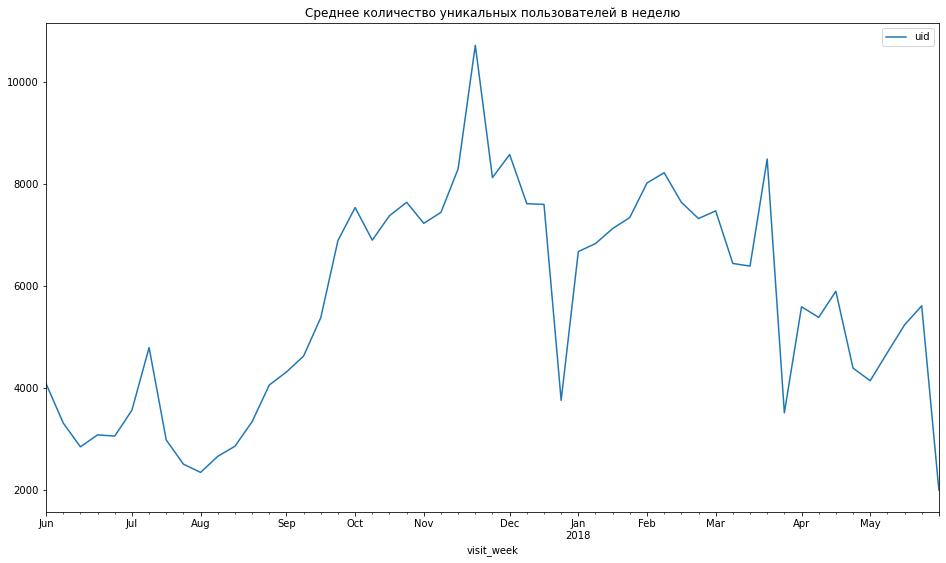

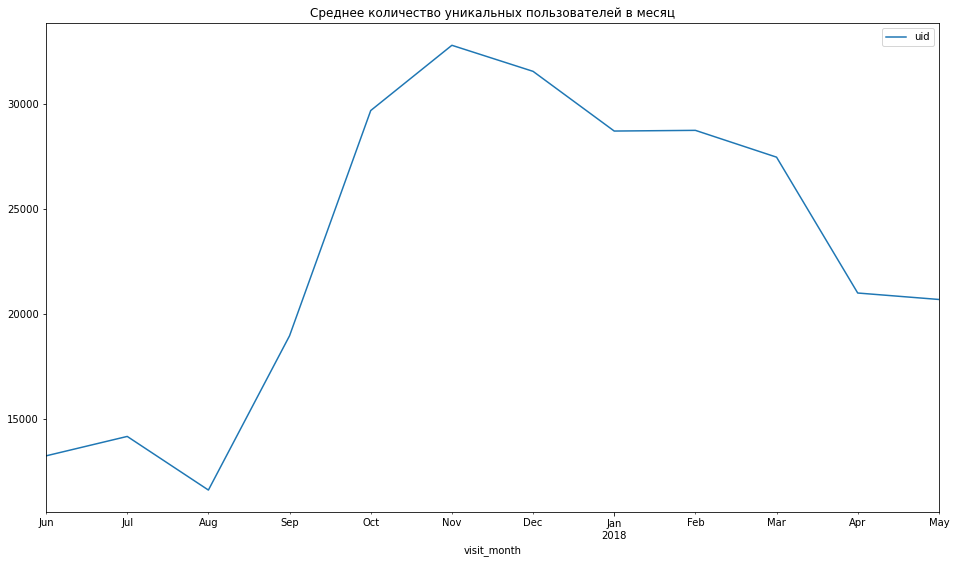

In [8]:
#рассчитаем DAU, WAU и MAU
dau_total = visits.groupby('visit_dt').agg({'uid': 'nunique'})
print('Среднее количество уникальных пользователей в день:', dau_total.mean())
dau_total.pivot_table(index=['visit_dt'], values = 'uid', 
                      aggfunc = 'mean').plot(
    figsize=(16,9),title = 'Среднее количество уникальных пользователей в день')

wau_total = (
    visits.groupby(['visit_year', 'visit_week'])
    .agg({'uid': 'nunique'})
    
)
wau_total.pivot_table(index=['visit_week'], values = 'uid', 
                      aggfunc = 'mean').plot(
    figsize=(16,9),title = 'Среднее количество уникальных пользователей в неделю')
print('Среднее количество уникальных пользователей в неделю:',wau_total.mean())

mau_total = (
    visits.groupby(['visit_year', 'visit_month'])
    .agg({'uid': 'nunique'})
    
)
mau_total.pivot_table(index=['visit_month'], values = 'uid', 
                      aggfunc = 'mean').plot(
    figsize=(16,9),title = 'Среднее количество уникальных пользователей в месяц')

print('Среднее количество уникальных пользователей в месяц:',mau_total.mean())

Судя по графику, точно можно быть уверенным, что после высокого процента привлечения клиентов, популярность сильно падает среди пользвателей новичков. Кривая нестабильна и очень чувствительна к рекламным кампаниям. В конце ноября 2017 и марта 2018 средний показатель аномален, вероятно произошли сбои в системе сбора данных. Следует обратить внимание, что в среднем в месяц за исследуемый период количество привлеченных клиентов увеличилось. За год показатель упал, новых потенциальных клиентов больше не заходит. 

In [9]:
#рассчитаем среднее количество сессий в день на одного пользователя
sessions_per_user = visits.groupby('visit_dt').agg(
    {'uid': ['count', 'nunique']}
)
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
).round(3)
print(sessions_per_user['sessions_per_user'].mean())

1.0821675824175825


643.506488592098
AxesSubplot(0.125,0.125;0.775x0.755)
0    60
dtype: int64


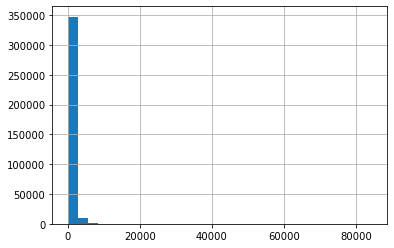

In [10]:
#рассчитаем типичную продолжительность пользовательской сессии за весь период
visits['session_duration_sec'] = (
    visits['visit_end_ts'] - visits['visit_start_ts']
).dt.seconds

print(visits['session_duration_sec'].mean())
#построим график распределния, чтобы выяснить более подходящую меру
print(visits['session_duration_sec'].hist(bins=30))
#при ненормальном распределении лучше использовать моду
print(visits['session_duration_sec'].mode()) 

Судя по средним показателям пользователь проводит на сайте минуту своего времени ежедневно.

<AxesSubplot:title={'center':'Cohorts: User Retention'}, xlabel='cohort_lifetime', ylabel='first_visit_month'>

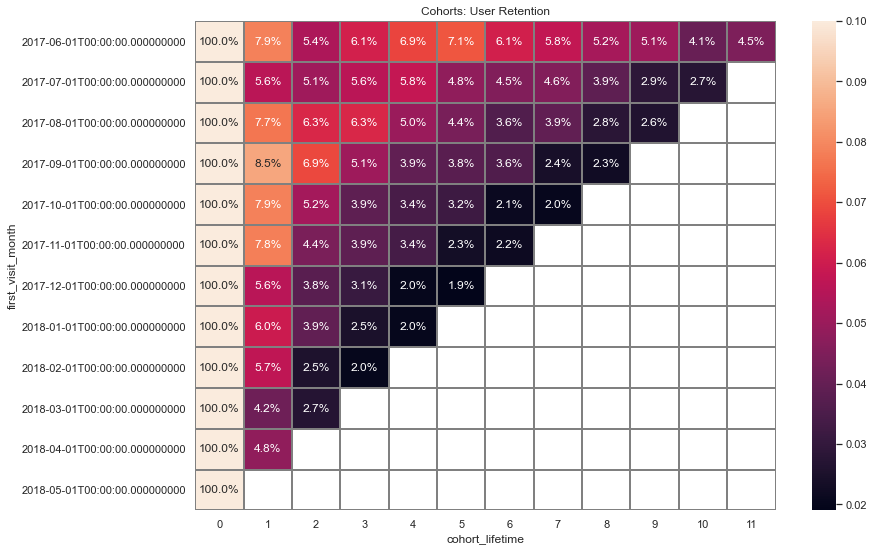

In [11]:
#рассчитаем RR
#сначала на когорты по сессиям
cohorts = visits_full.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

initial_users_count = cohorts[cohorts['cohort_lifetime']== 0][['first_visit_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

cohorts = cohorts.merge(initial_users_count,on='first_visit_month')

cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

retention_pivot
#а теперь красиво
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', vmax=0.1,linewidths=1, linecolor='gray')

Коэффициент удержания в среднем стабильный, однако с декабря 2017 года новые когорты стали показывать результаты хуже. Возможно, в праздничные периоды людей беспокоят другие покупки и удержать их внимание на яндекс.афише стало сложнее.

2.2. Метрики электронной коммерции
2.2.1. Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. Изучать изменение этой метрики во времени необязательно;
2.2.2. !!!!!Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. Изучать изменение этой метрики во времени необязательно;
2.2.3. Рассчитайте средний чек;
2.2.4. Выясните, как меняется во времени LTV на покупателя по когортам. Помните, что LTV — накопительная метрика. Рассчитайте средний LTV по когортам за 6 месяцев; в расчёт включайте когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%.

## Метрики электронной коммерции

AxesSubplot(0.125,0.125;0.775x0.755)
Мода по количеству дней от первой сессии к первому заказу: 0    0
dtype: int32
Среднее количество дней от первой сессии к первому заказу: 16.895901212934316


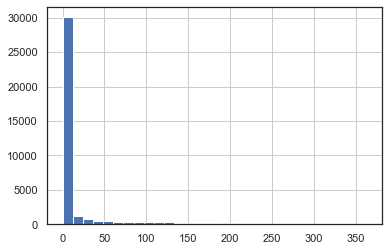

In [12]:
#рассчитаем среднюю длительность перехода из первой сессии в первый заказ

#смеджерим первые сессии и заказы
potential_clients = pd.merge(first_orders,first_visits, on ='uid')

#добавим столбец с разницей между днем первой сессией и днем первой покупки (в днях)
potential_clients['visit_into_order'] = (
    potential_clients['first_order_dt'] - potential_clients['first_visit_dt']
)
potential_clients['visit_into_order']= potential_clients['visit_into_order']/ np.timedelta64(1,'D')
potential_clients['visit_into_order']=potential_clients['visit_into_order'].round(0).astype('int')

#построим график распределния, чтобы выяснить более подходящую меру
print(potential_clients['visit_into_order'].hist(bins=30))
#распределение ненормальное, поэтому лучше использовать моду
#здесь и ответ на вопрос почему в первый раз - первый заказ: ведь разница в ноль дней

print('Мода по количеству дней от первой сессии к первому заказу:',potential_clients['visit_into_order'].mode())
print('Среднее количество дней от первой сессии к первому заказу:',potential_clients['visit_into_order'].mean())

Часто первая сессия и становится первым заказом, но среднее значение между уверенными и неуверенными в своем решении покупать пользователями составляет 17 дней от первой сессии до первого заказа.

In [13]:
#рассчитаем среднее количество покупок на 1 пользователя за 6 месяцев
orders_2 = pd.merge(orders,first_orders, on='uid') 

#отсортируем 6месячный период
#orders_2=orders_2.query('"2017-06-01 00:00:00" <= order_month < "2018-01-01 00:00:00"')

orders_per_one_buyer_6 = orders_2.groupby(['first_order_month', 'order_month']
                                         ).agg({'revenue': 'count', 'uid': 'nunique'})

orders_per_one_buyer_6.columns = ['n_orders', 'n_users']
orders_per_one_buyer_6['mean_orders_per_buyer']=orders_per_one_buyer_6['n_orders']/orders_per_one_buyer_6['n_users']
orders_per_one_buyer_6['mean_orders_per_buyer']=orders_per_one_buyer_6['mean_orders_per_buyer'].round(2)

print(orders_per_one_buyer_6['mean_orders_per_buyer'].mean())

1.858987341772152


In [14]:
#рассчитать средний чек
revenue_per_one_buyer = orders_2.groupby(['first_order_month', 'order_month']
                                          ).agg({'revenue': 'sum', 'uid': 'nunique'})


revenue_per_one_buyer.columns = ['revenue', 'n_users']

revenue_per_one_buyer['revenue_per_user'] = (
    revenue_per_one_buyer['revenue']
    / revenue_per_one_buyer['n_users']
)
revenue_per_one_buyer.pivot_table(
    index='first_order_month',
    columns='order_month',
    values='revenue_per_user',
    aggfunc='mean',
)


order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


Судя по показателю среднего чека пользователя клиент удовлетворен своим заказом, раз продолжает покупать больше. Коэффициент доверия в принципе высокий, особенно у тех, кто покупает с июня 2017 года и сентября 2017 года, а вот остальные когорты скорее параболически растут и падают. В сентябрьской когорте даже есть супер аномальное значение...

<AxesSubplot:title={'center':'LTV'}, xlabel='age', ylabel='first_order_month'>

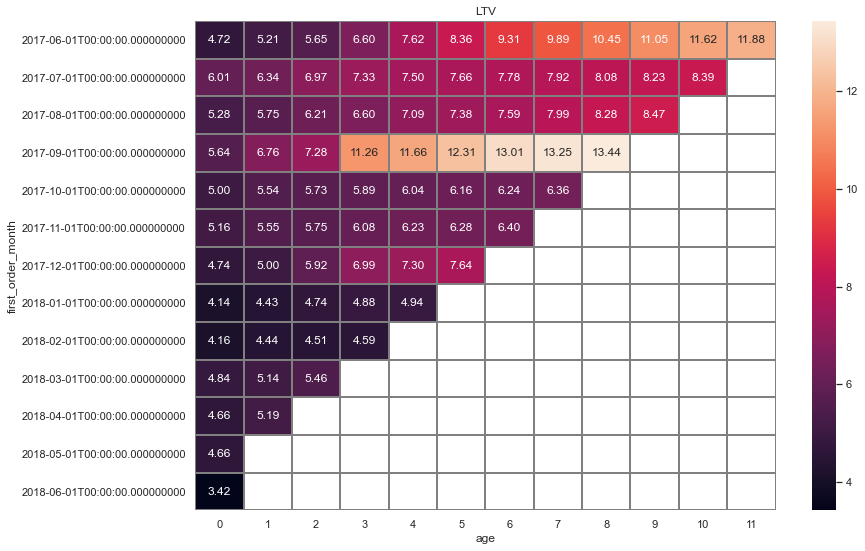

In [15]:
#рассчитаем LTV
margin_rate = 1
#посчитаем количество новых покупателей за каждый месяц
cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']

#cгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = (
    orders_2.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']

result = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean'
).round(3).cumsum(axis=1)

#а теперь красиво
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(result, annot=True,linewidths=1, linecolor='gray',fmt='.2f')

"Пожизненная стоимость клиента" стабильна, в июньской и сентябрьской когорте, показывает наиболее высокие результаты.

2.3.1. Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам;
2.3.2. Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика;
2.3.3. Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV.

## Марктинговые методы

<AxesSubplot:title={'center':'Затраты по привлечению в каждом источнике за весь период'}, xlabel='cost_month'>

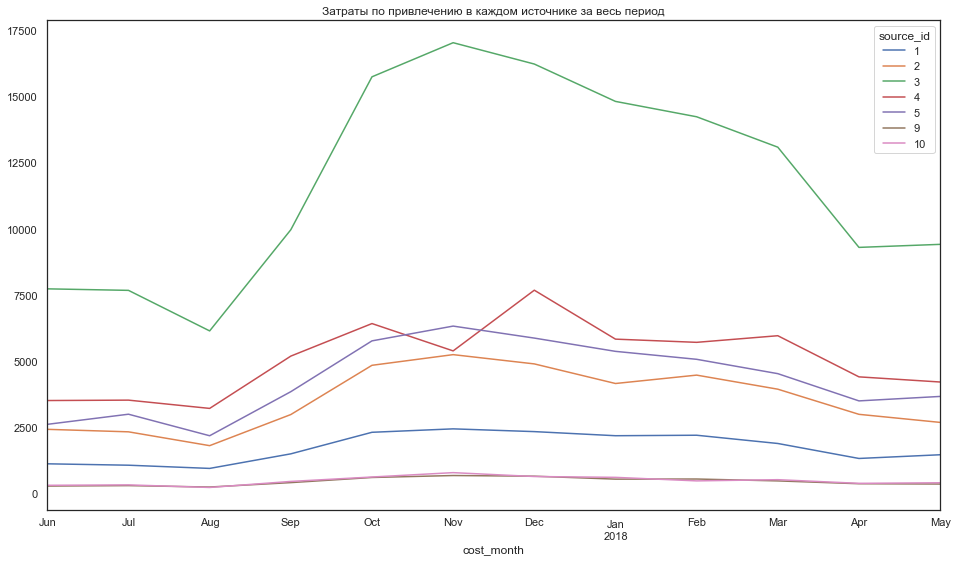

In [16]:
#распределение затрат по источникам привлечения
costs_per_source = costs.groupby(['cost_month','source_id'])['costs'].sum().reset_index()

costs_per_source.pivot_table(index=['cost_month'], columns = 'source_id',values = 'costs').plot(
    figsize=(16,9),title = 'Затраты по привлечению в каждом источнике за весь период')

На 3 источник ушло больше всего затрат, посмотрим, насколько он окупился в долгосрочной перспективе. Номера 4 5 и 2 держат примерно одинаковые позиции, хотя есть и более ресурсозатратные варианты.

In [17]:
#посчитаем САС для всего проекта в месяц
monthly_costs = costs.groupby('cost_month').sum().reset_index()

report_new = pd.merge(
    report, monthly_costs, left_on='first_order_month', right_on='cost_month'
)

report_new['cac'] = report_new['costs'] / report_new['n_buyers']

report_cac =report_new.pivot_table(
    index='first_order_month',
    values='cac',
    aggfunc='mean')

report_cac

,cac
first_order_month,
2017-06-01,8.905091
2017-07-01,9.485486
2017-08-01,10.796015
2017-09-01,9.441654
2017-10-01,8.369327
2017-11-01,9.288870
2017-12-01,8.741809
2018-01-01,9.937302
2018-02-01,8.962758


In [18]:
report_new['romi']= report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean'
)

output.cumsum(axis=1).round(2) 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Самая высокая стоимость привлечения пришлась на август, причем в сентябре удалось привлечь много новых пользователей и увеличить средний чек.

In [19]:
#посчитаем САС по дням
#найдем первый рекламный источник, благодаря которому юзер у нас
visits = visits.rename (columns= {'source id': 'source_id'})
users=visits.sort_values('visit_start_ts').groupby('uid').first()
users = users[['source_id']]
users.head()

,source_id
uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5


<AxesSubplot:title={'center':'Стоимость привления одного покупателя из каждого источника'}, xlabel='cost_month'>

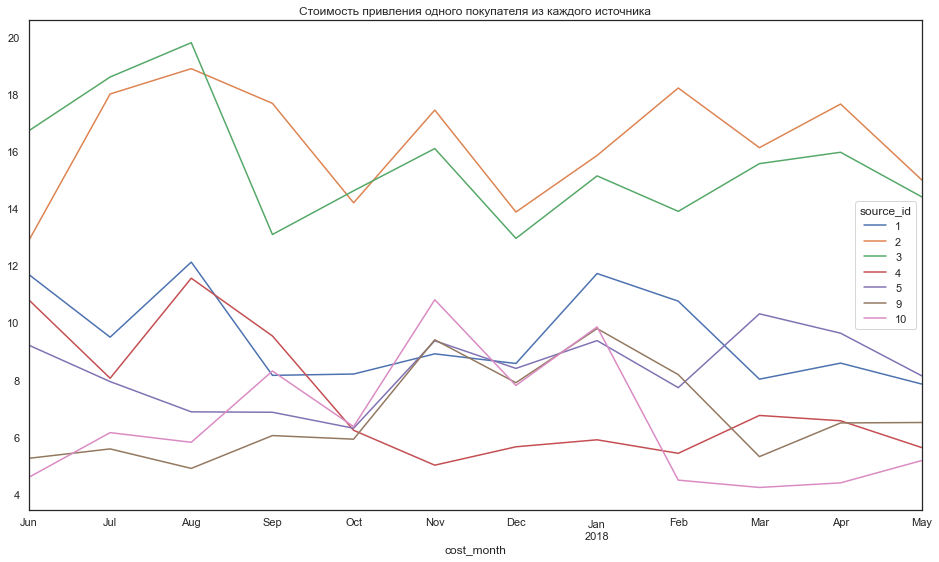

In [20]:
potential_clients = pd.merge(potential_clients,users, on = 'uid')

potential_clients_daily = potential_clients.groupby(['source_id','first_order_dt']).agg({'uid':'count'}).reset_index()
potential_clients_daily.rename(columns={'uid':'n_buyers'},inplace=True)

#смеджерим с затратами на каждый ресурс и рассчитаем среднее
costs_new = pd.merge(potential_clients_daily,costs, left_on = ['source_id','first_order_dt'], right_on = ['source_id','dt'])
costs_new['cac'] = costs_new['costs']/costs_new['n_buyers']

#display(costs_new)

costs_new.pivot_table(index=['cost_month'], columns = 'source_id',values = 'cac', 
                      aggfunc = 'mean').plot(
    figsize=(16,9),title = 'Стоимость привления одного покупателя из каждого источника')

Стоимость привлечения одного клиента по источникам 3 и 2 самая высокая, данный показатель подтвердил то, что два этих источника самые ресурсозатратные.

In [21]:
orders_3 = pd.merge(orders_2,users, on = 'uid')
orders_3.head()

,buy_ts,revenue,uid,buy_dt,order_month,order_week,min_buy_ts,first_order_dt,first_order_month,first_order_week,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01,3


<AxesSubplot:title={'center':'Окупаемость каждого источника'}, xlabel='cost_month'>

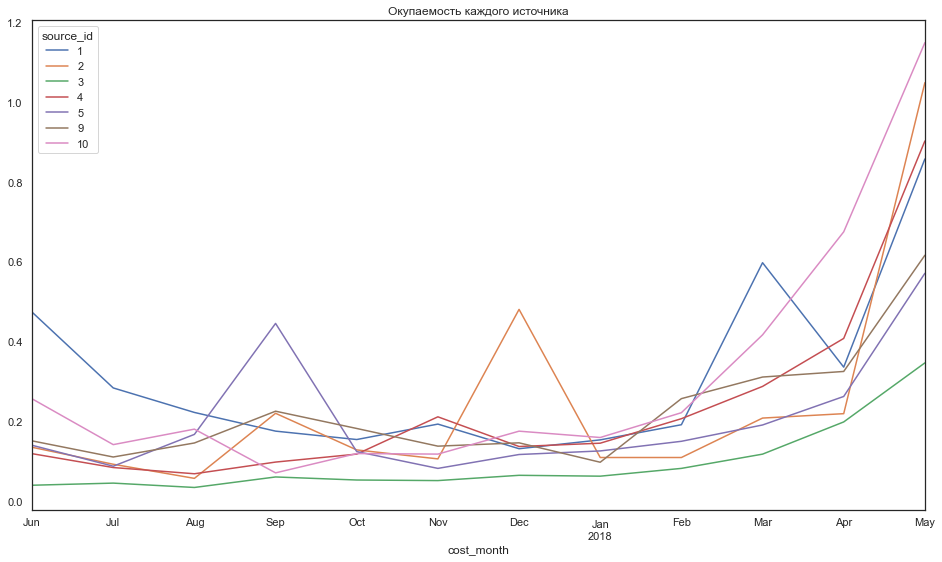

In [22]:
users=visits.sort_values('visit_start_ts').groupby('uid').first()
users = users[['source_id']]

dt = pd.merge(orders,users, on = 'uid')
#dt['buy_ts']=dt['buy_ts'].dt.date
dt_first = dt.groupby(['uid','source_id'])['buy_dt'].min().reset_index()
dt_first.columns = ['uid','source_id','first_buy_dt']
dt_first['first_buy_month'] = dt_first['first_buy_dt'].astype('datetime64[M]')

cohort_sizes = (
    dt_first.groupby(['first_buy_month','source_id'])
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month','source_id', 'n_buyers']

cohorts = (
    orders_3.groupby(['first_order_month','order_month','source_id'])
    .agg({'revenue': 'sum'})
    .reset_index()
)

report = pd.merge(cohort_sizes, cohorts, left_on=['first_order_month','source_id'], right_on=['first_order_month','source_id'])

costs_by_source = costs.groupby(['cost_month','source_id'])['costs'].sum().reset_index()

romi = pd.merge(report,costs_by_source, left_on = ['first_order_month','source_id'], right_on = ['cost_month','source_id'])

romi['ltv'] = romi['revenue']/romi['n_buyers']
romi['cac'] = romi['costs']/romi['n_buyers']
romi['romi'] = romi['ltv']/romi['cac']


romi.pivot_table(index=['cost_month'], columns = 'source_id',values = 'romi', 
                      aggfunc = 'mean').plot(
    figsize=(16,9),title = 'Окупаемость каждого источника')


В топ по окупаемости вырвались источники 10 и 2,4 и 1. А вот один из самых дорогих источников 3 не дал о себе знать, результат явно не оправдывает затраты на него.

ОБЩИЙ ВЫВОД: самое главное преимущество сервера Яндекс.Афиши в том, что пользователи ему доверяют, следовательно, чем больше пользователей привлечено, тем больше в долгосрочной перспективе выручки они принесут. 
За весь исследуемый период выявлены аномалии, на которые стоит обратить внимание: количество новых пользователей в ноябре и конце марта показало невероятные результаты. Стоит обратить внимание, какие рекламные компании могли выстрелить в эти дни, либо проверить совершались ли сбои в системе сбора данных в этот период. Скорее всего это просто сбой, т.к. другие метрики не оказались чувствительны к выбросам в эти месяцы. Иная аномалия выявлена по сентябрьской когорте в среднем чеке, скорее всего это большой заказ, который сильно сбил показатели по этой когорте.

Что касается источников, наиболее затратными как в целом по источникам, так и в среднем по привлечению на одного пользователя оказались источники 2 и 3. При всем этом у 3 источника - низкий показатель результативности, следовательно, стоит больше не прибегать к его использованию. Однако лучшим по соотношению затраты по привлечению - результат, можно выделить источник 10.